In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
import timm
import os
import torch
import glob
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torchinfo import summary

# Load test images

In [4]:
folder_name = './test_images'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

    # Use wget to download the image into the folder
    !wget -P {folder_name} https://img.delicious.com.au/aChNQyIi/w759-h506-cfill/del/2015/10/no-churn-ice-cream-four-ways-15139-2.jpg
    !wget -P {folder_name} https://preppykitchen.com/wp-content/uploads/2023/08/Apple-Pie-Recipe-Recipe-Card.jpg
    !wget -P {folder_name} https://www.justonecookbook.com/wp-content/uploads/2023/04/Spicy-Shoyu-Ramen-8055-I.jpg

--2024-03-23 16:48:50--  https://img.delicious.com.au/aChNQyIi/w759-h506-cfill/del/2015/10/no-churn-ice-cream-four-ways-15139-2.jpg
Resolving img.delicious.com.au (img.delicious.com.au)... 23.47.0.144
Connecting to img.delicious.com.au (img.delicious.com.au)|23.47.0.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93449 (91K) [image/jpeg]
Saving to: ‘./test_images/no-churn-ice-cream-four-ways-15139-2.jpg’

no-churn-ice-cream- 100%[===================>]  91.26K  --.-KB/s    in 0.06s   

2024-03-23 16:48:51 (1.37 MB/s) - ‘./test_images/no-churn-ice-cream-four-ways-15139-2.jpg’ saved [93449/93449]

--2024-03-23 16:48:51--  https://preppykitchen.com/wp-content/uploads/2023/08/Apple-Pie-Recipe-Recipe-Card.jpg
Resolving preppykitchen.com (preppykitchen.com)... 104.18.4.29, 104.18.5.29, 2606:4700::6812:41d, ...
Connecting to preppykitchen.com (preppykitchen.com)|104.18.4.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45628 (45K) [imag

# Load pre-train weight

In [5]:
# Check gpu availability with pytorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
NVIDIA GeForce RTX 4050 Laptop GPU


In [6]:
# Load your model from the Hub
model_reloaded = timm.create_model(
    'hf_hub:ceram1324/my-finetuned-mobilenetv3',
    pretrained=True
)
model = model_reloaded.eval()

In [7]:
# Put the model on the device
model = model.to(device)

In [8]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3                                   [1, 10]                   --
├─Conv2d: 1-1                                 [1, 16, 112, 112]         432
├─BatchNormAct2d: 1-2                         [1, 16, 112, 112]         32
│    └─Identity: 2-1                          [1, 16, 112, 112]         --
│    └─Hardswish: 2-2                         [1, 16, 112, 112]         --
├─Sequential: 1-3                             [1, 576, 7, 7]            --
│    └─Sequential: 2-3                        [1, 16, 56, 56]           --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 16, 56, 56]           744
│    └─Sequential: 2-4                        [1, 24, 28, 28]           --
│    │    └─InvertedResidual: 3-2             [1, 24, 28, 28]           3,864
│    │    └─InvertedResidual: 3-3             [1, 24, 28, 28]           5,416
│    └─Sequential: 2-5                        [1, 40, 14, 14]           --
│    │    └─

In [9]:
folder_path = "./test_images"
image_files = glob.glob(os.path.join(folder_path, "*.jpg")) + glob.glob(os.path.join(folder_path, "*.jpeg")) + glob.glob(os.path.join(folder_path, "*.png"))
image_files

['./test_images/Apple-Pie-Recipe-Recipe-Card.jpg',
 './test_images/no-churn-ice-cream-four-ways-15139-2.jpg',
 './test_images/Spicy-Shoyu-Ramen-8055-I.jpg']

In [ ]:
# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to x, y
    transforms.ToTensor(),        # Convert images to PyTorch tensors
])

In [11]:
class_name = ["apple pie", "bibimbap", "cannoli", "edamame", "falafel", "french toast", "ice cream", "ramen", "sushi", "tiramisu"]

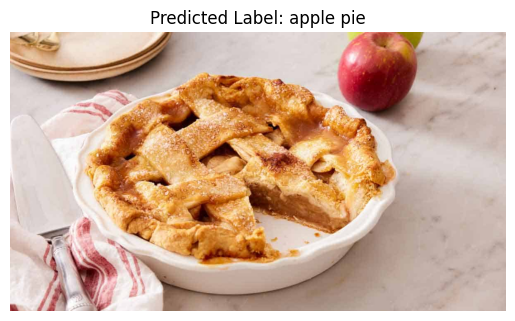

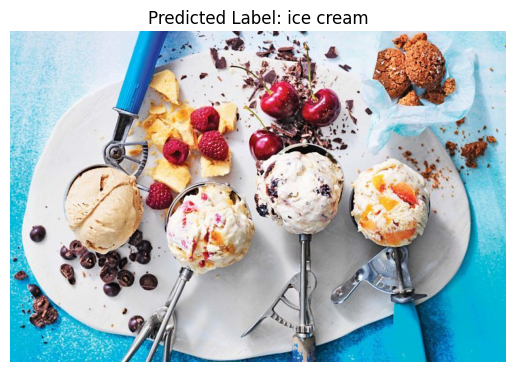

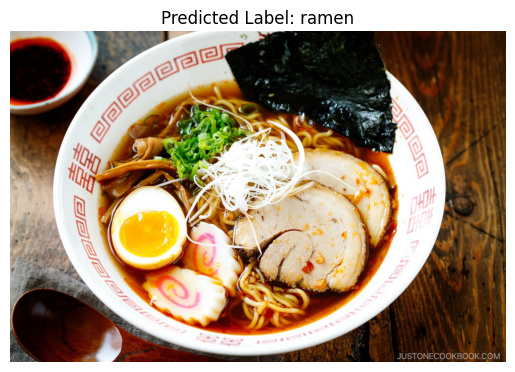

In [14]:
for image_file in image_files:
  # Open the image file
  img = Image.open(image_file)
  # Apply the transformation
  img = transform(img)
  # Add batch dimension
  img = img.unsqueeze(0)
  # Move image to GPU if available
  img = img.to(device)
  # Disable gradient calculation
  with torch.no_grad():
    # Perform prediction
    outputs = model(img)
    # Get predicted class
    _, predicted = torch.max(outputs, 1)

  plt.imshow(Image.open(image_file))
  # Set the title with the predicted label
  plt.title(f"Predicted Label: {class_name[predicted.item()]}")
  # Hide the axes
  plt.axis('off')
  # Show the plot
  plt.show()